## Solution Overview:

In [ ]:
# Install requirements.txt files
!pip install -r requirements.txt

In [ ]:
# Import necessary modules
from src.utils import *
import pandas as pd

## 1.1 Data Preprocessing

To ensure comprehensive representation of varied seismic formations, K-Means clustering was applied to the training data to identify natural seismic groupings (6 clusters in total). These groupings allow us to perform stratified K-Fold validation, ensuring that each fold contains a balanced representation of all seismic groups in both training and testing sets.

**Note**:

Unzip train_data, train_extended_1, train_extended_2, and test into their respective folders: train_data, train_extended_1, train_extended_2, and test_data under folder data.

- unzip train.zip -d ./data/train_data
- unzip train_extended_1.zip -d ./data/train_extended_1
- unzip train_extended_2.zip -d ./data/train_extended_2
- unzip test.zip -d ./data/test_data

Place all these folders inside the main data directory, following the specified folder structure.

-data/
- train_data/
- train_extended_1/
- train_extended_2/
- test_data/


Run src/prepare_data_train.py once to perform K-Means clustering and generate CSV files for the 5 folds of stratified K-Fold splits based on seismic groups.

When running the script, specify the absolute path to the data folder using the --dataset command-line argument.

In [ ]:
!python src/prepare_data_train.py \
    --dataset "/notebooks/speed_structure/flamethrower_Speed_Structure_Submission/data" \
    --num_folds 5 \
    --seed 42

### Explore the Clustering Group and distribution

In [ ]:
# Load one fold and visualise velocity groups
df = pd.read_csv('./data/val_fold4.csv')

In [ ]:
visualise_velocity_group(df, seismic_group=0, num_samples=4)

In [ ]:
visualise_velocity_group(df, seismic_group=1, num_samples=4)

In [ ]:
visualise_velocity_group(df, seismic_group=2, num_samples=4)

In [ ]:
visualise_velocity_group(df, seismic_group=3, num_samples=4)

In [ ]:
visualise_velocity_group(df, seismic_group=4, num_samples=4)

In [ ]:
visualise_velocity_group(df, seismic_group=5, num_samples=4)

In [ ]:
plot_seismic_group_distribution(df)

Based on the exploratory data analysis, the dataset presents different unique representations in the dataset and having a good balance of the cases is essential for generalisation across the different cases. To ensure good representation, the validation set encompasses the different seismic groups split in a stratified manner.

## 1.2 Model Description:

My approach builds upon an EVA Vision Transformer backbone for multi-channel regression, designed specifically for multi-channel information processing and fusion  prediction. The raw seismic data is treated like an image by pre-processing into a format suitable for Vision Transformer. The model uses a modified timm-based ViT with dynamic image size support and single-channel patch embeddings, enabling each of the 5 input channels to be processed independently before feature fusion. The Transformer is divided into two stages: early blocks capture fine-grained, channel-specific information, while later blocks process the fused multi-channel representation to produce the final prediction. EVA Large Patch14 Backbone was used for all models.

A strong attention-based strategy is employed through a Multi-Head Attention (MHA) mechanism https://arxiv.org/abs/1706.03762 to capture relationships across sources. 

Depending on the configuration, fusion of information from sources can be performed via a single MHA followed by mean aggregation, or a dual-stage MHA for deeper integration. Source positional embeddings help the model attend to different channel positions, further improving fusion quality. 
Using MHA improved the quality of the model in processing information from different sources and obtaining a fused representation to facilitate more accurate seismic velocity predictions.

**The model workflow is as follows**:

>> Input Data Processing: The seismic data is reshaped and reordered to make it suitable for 2D convolution and ViT patch embedding: Reshape into (N, 5, 100, 100, 31) to break down the large spatial dimension, permute, flatten then interpolate (resize) the spatial dimensions to (560, 560) to to align with the model’s patch embedding requirements, producing an output size near 1259.

>> Per-Channel Processing: Each channel is patch-embedded and passed through the first split_at transformer blocks independently.

>> Channel Fusion: Features are fused via either single-MHA (with mean aggregation) or dual-stage MHA, controlled by the channel_fusion parameter. For Channel Attention,the sources are used as queries, key and value. While for Fusion Attention, the query is a single fused 
dimension, while the sources are used as keys and values. 

>> Fused Processing: The fused token sequence is processed by the remaining transformer blocks.

>> Prediction Head: Features are normalized, CLS tokens removed, projected to 300 dimensions, and 560/14 * 560/14(40*40) is interpolated to a (300 × 1259) grid. A sigmoid activation scales predictions into the target velocity range [global_min_y, global_max_y].

**Special Features**:

>>Dual Inference Mode: Supports both training and test modes, with Test-Time Augmentation (TTA) using horizontal flipping and median prediction fusion in test mode.

>>Configurable Fusion: Selectable single- or dual-MHA strategies for channel integration.

>>Target-Specific Scaling: Outputs scaled to match the physical range of seismic velocity distributions.

**Modelling Approach**: Following this outlined modelling strategy, 3 different models were trained for each fold of the data with diversity regarding split at or the Multi-Head Attention setup:

>> One model trained with split 10, 4 MHA for Channel Attention, 2 MHA for Fusion Attention - Folds 0, 1, 2, 3, 4

>> One model trained with split 10, 2 MHA for Channel Attention, 2 MHA for Fusion Attention - Folds 1, 2, 3, 4

>> One model trained with split 9, 4 MHA for Channel Attention, 4 MHA for Fusion Attention - Fold 0

>> One model trained with split 10, 4 MHA for Channel Attention, No Fusion Attention - Folds 0, 1, 2, 3, 4

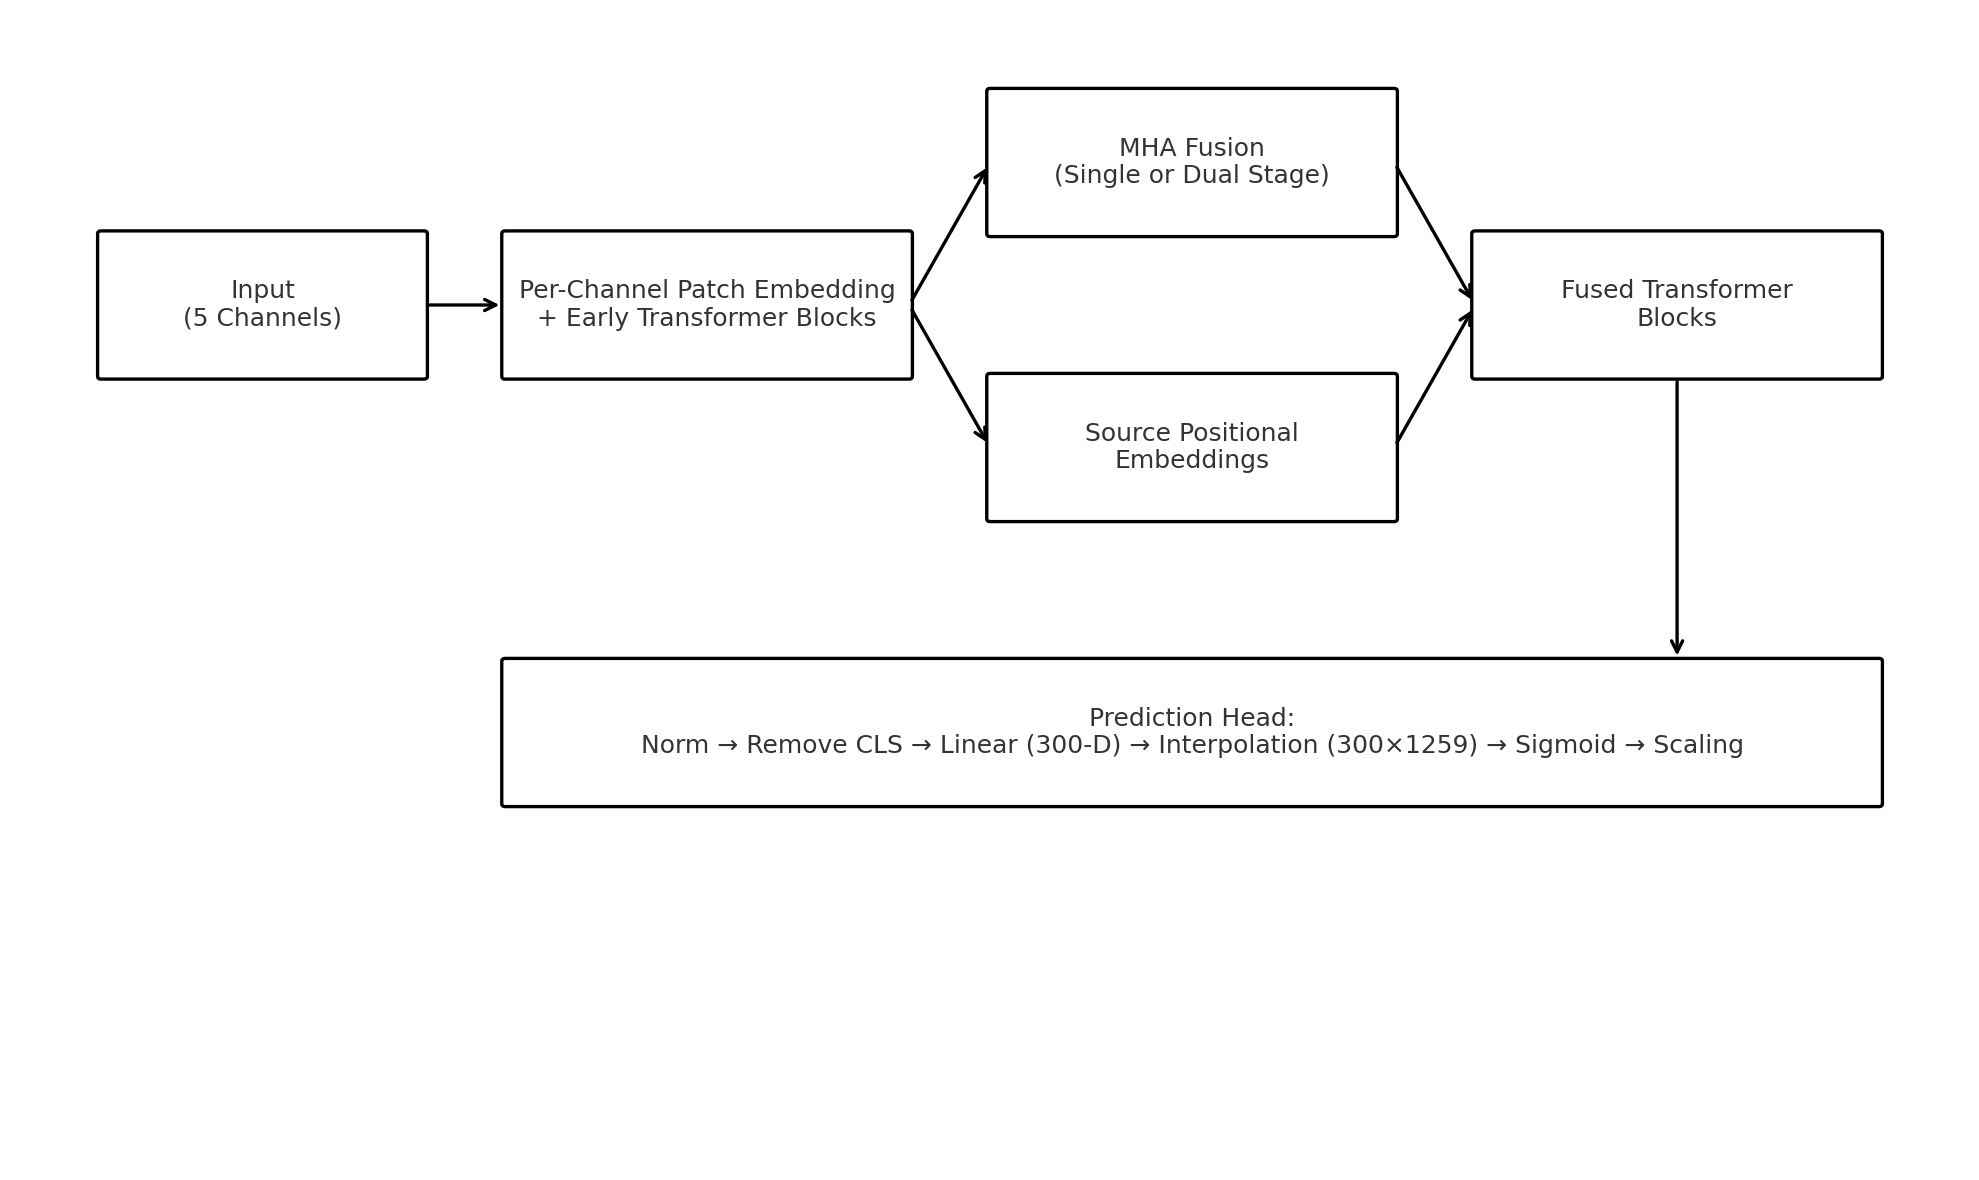

## 1.3 Training Strategy:

The training procedure begins with pre-processing the seismic data by removing multiples using a factor of 1e-3 within the dataset loader, which helps the model converge more quickly. Training is performed with a batch size of one, allowing the model to concentrate on detailed source-specific information during channel processing with attention mechanisms. Training is done using the Timm pre-trained weight initialisation of the specific backbone, this enables better performance.

The model is optimized using the MuonWithAuxAdam Optimizer, further accelerating convergence. Additionally, data augmentation is applied by horizontally flipping the receiver axes during training. Following these steps, the model can be effectively trained over 25 epochs to achieve optimal performance.


## 1.4 Training Reproduction:

**Prerequisites:** Make sure your data folder is prepared with: CSV files for the folds (generated from prepare_data_train.py).All seismic data subfolders (train_data, train_extended_1, etc.) should be in same directory as CSV files

Folder structure example:

- data/
  - fold_0.csv
  - fold_1.csv
  ...
  - train_data/
  - train_extended_1/
  - train_extended_2/
  - test_data/
  
  
In the src directory, there are 4 individual training scripts, all beginning with train_*****.py.
No changes to the configuration inside these scripts are required to run them.
  

**train_EVA_16_*.py Arguments**

Model Training Parameters:

- --epochs: Number of training epochs (default: 30)
- --lr: Learning rate (default: 1e-4)
- --ema_decay: Exponential Moving Average decay parameter (default: 0.99)
- --batch_size: Batch size for training (default: 1)
- --accumulation_steps: Number of steps for gradient accumulation (default: 2)
- --num_workers: Number of CPU workers for data loading (default: number of CPU cores)
- --Encoder: Encoder model name (default: "eva02_large_patch14_448.mim_in22k_ft_in22k_in1k")
- --name: Experiment name or identifier (default: "EVA_16_Large_Split_10_Multi_MHA_4_heads")
- --device: Device to run training ('cuda' if available, otherwise 'cpu')
- --sub_dir: Directory to save submissions (default: "../Submissions")
- --T_0: Scheduler parameter, typically for cosine annealing (default: 100)
- --min_lr: Minimum learning rate (default: 5e-5)
- --val_batch_size: Batch size for validation (default: 16)
- --trained: Flag to indicate if model is pre-trained (default: False)
- --seed: Random seed for reproducibility (default: 42)

Run-Time Parameters: This can be executed to run a Single Fold for One Model
- --fold: Specific fold to train on
- --data_dir: Path to data directory (must contain fold CSVs and seismic data subfolders)
- --sub_dir: Directory to save model checkpoints

Example:

>> python src/train_EVA_16_Large_Split_10_Multi_MHA_4_heads.py \
      --fold 0 \
      --data_dir "/absolute/path/to/data" \
      --sub_dir "/absolute/path/to/save/checkpoints"




---------------------------------------------------------------------------------------
**Note: Running All Folds for All Models Automatically**:

To reproduce the full solution across all models and folds: Running All Folds for All Models Automatically. 

>> The script run_training.py automates this process by: Iterating through folds and iterating through all train_EVA_16_***.py scripts following fold assignments from model_folds.yaml. 

>> The arguments for each model script are already configured as per the defaults listed above in Model Training Parameters. Model checkpoints will be saved in the --sub_dir path. 

>> Training logs should display: The current model script being executed, The fold number and Metrics such as loss and validation performance

>> **run_training.py Run-time Arguments**
>> - --data_dir: Path to data directory (must contain fold CSVs and seismic data subfolders)
>> - --sub_dir: Directory to save model checkpoints

>> The run_training.py is already set with the runtime arguments in the file, assuming a folder structure where run_training.py is in same folder with data and Submissions

In [ ]:
# ! python src/train_EVA_16_Large_Split_10_Single_MHA_4_heads.py \
#       --fold 2 \
#       --data_dir "/notebooks/speed_structure/flamethrower_Speed_Structure_Submission/data" \
#       --sub_dir "/notebooks/speed_structure/flamethrower_Speed_Structure_Submission/Submissions"

In [ ]:
# Example Usage
! python run_training.py

## 1.5 Inference Reproduction

## Overview

>> Inference uses an ensembling approach: For each fold, the 3 models trained for that fold are combined using a weighted mean. Predictions from all folds are then mean-averaged to produce the final output.

**Steps to Run Inference for the Holdout Dataset**

- Step 1 — Prepare Test Data: Run the test data preparation script to generate the CSV needed by the dataloader: "dataset" should point to the folder containing the holdout test data.This script will create a test.csv file:

>>python src/prepare_data_test.py \
      --dataset "/absolute/path/to/data"


- Step 2 — Configure predict.py Arguments within .py file

 >> The main inference script is predict.py. Below are its key arguments:

>> - --device: Device for inference ('cuda' if available, otherwise 'cpu')

>> - --ckpt_root: Root directory containing trained model checkpoints (default: "./speed_structure_checkpoints/Checkpoints")

>> - --sub_path: Output path for submission file (default: "./Submissions/Final_holdout_test_sub.npz")

>> - --test_path: Path to test dataset CSV file (default: "./data/test.csv")

>> - --num_workers: CPU workers for dataloader (default: number of CPU cores)

>> - --num_folds: Number of folds to include in prediction (default: 5)

>> - --val_batch_size: Batch size for validation/inference (default: 16)

>> Example command:
        python predict.py 


**Inference Configuration Caveat**

For a smooth run, keep the same folder structure as outlined in the folder structure/organisation: 

Run predict.py from the directory containing both: The data folder, The speed_structure_checkpoints folder. This ensures that relative paths in the script resolve correctly.

In [ ]:
!python src/prepare_data-test.py \
--dataset "/notebooks/speed_structure/flamethrower_Speed_Structure_Submission/data"

In [ ]:
!python predict.py